<a href="https://colab.research.google.com/github/kmay9270/AIML-Projects-USD-MSAAI-Team7/blob/main/Team7_WIP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Statistical Coding Assignment: Regression Analysis of Medical Insurance Cost Across US regions

Students: **Emmanuel Sadek, Mayur Khare, and Jinyuan He**

Date: **09/30/2025**

This notebook serves as the technical foundation for our statistical coding assignment, focusing on the [Medical Insurance Cost dataset](https://www.kaggle.com/datasets/mosapabdelghany/medical-insurance-cost-dataset/) from Kaggle. This project is a collaborative effort by .

The analyses and code within this notebook directly support the sections of our technical report, which will include:

*   **Introduction:** Briefly introducing the problem and dataset.
*   **Data Cleaning/Preparation:** Detailing the steps taken to clean and prepare the data for analysis.
*   **Exploratory Data Analysis:** Presenting visualizations and summaries to understand the data's characteristics and relationships.
*   **Model Selection:** Explaining the rationale behind choosing specific models for predicting medical insurance costs.
*   **Model Analysis:** Evaluating the performance of the selected models.
*   **Conclusion and Recommendations:** Summarizing our findings and providing recommendations based on the analysis.

This notebook contains the executed code and outputs that will be included in the appendix of our technical report. We will use this notebook to perform the following steps:

*   **Load and Prepare the Data:** Import the dataset and perform any necessary cleaning or transformations.
*   **Conduct Exploratory Data Analysis:** Generate visualizations and descriptive statistics.
*   **Develop and Analyze Models:** Build and evaluate models for predicting medical insurance costs.

Through this notebook, we aim to systematically analyze the medical insurance cost dataset and generate the necessary outputs for our comprehensive technical report.

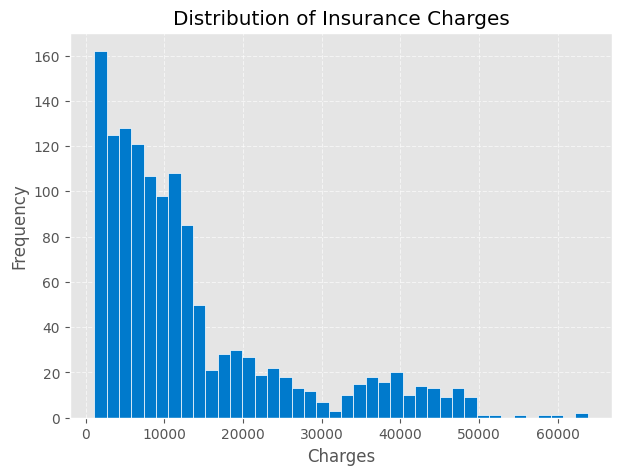

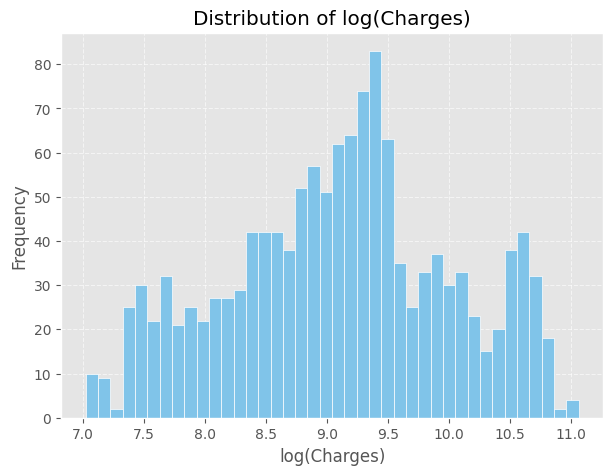

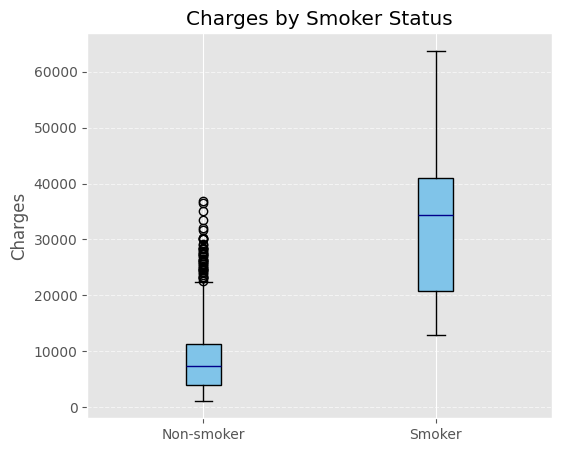

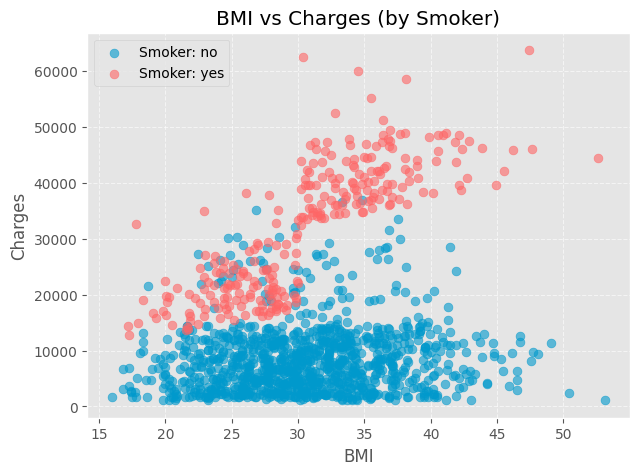

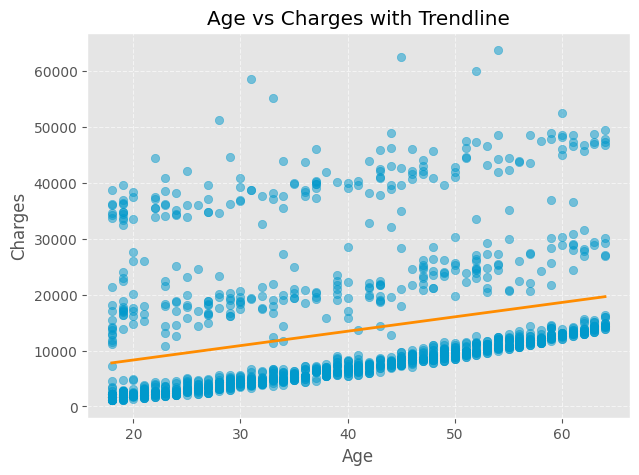

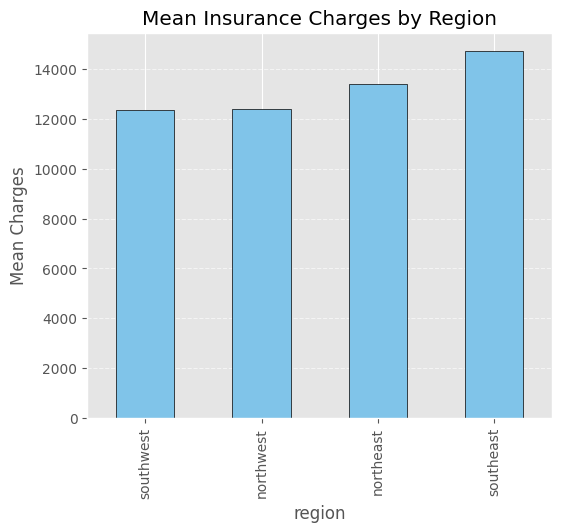

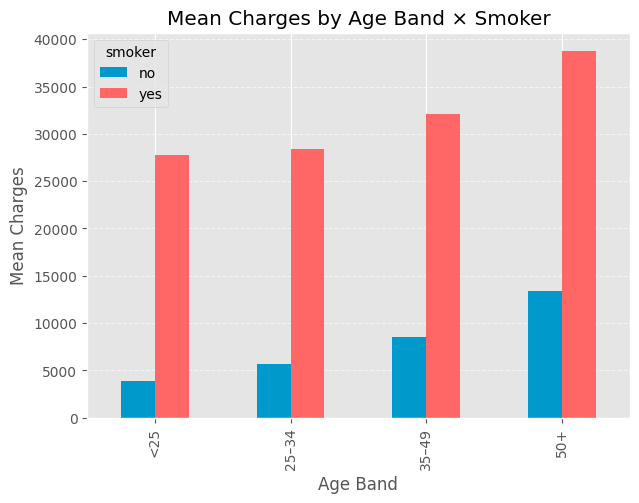

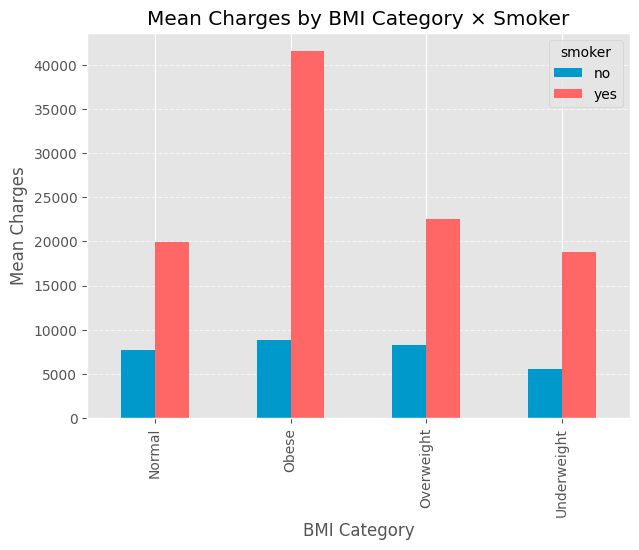

In [35]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

url = "https://raw.githubusercontent.com/kmay9270/AIML-Projects-USD-MSAAI-Team7/refs/heads/main/insurance.csv"
df = pd.read_csv(url)

# Clean column names
df.columns = [c.strip().lower() for c in df.columns]

# Convert categorical columns to lowercase
for c in ['sex', 'smoker', 'region']:
    df[c] = df[c].astype(str).str.lower().str.strip()

# -----------------------------------------------
# 1. Histogram – Distribution of Insurance Charges
# -----------------------------------------------
plt.figure(figsize=(7,5))
plt.hist(df['charges'], bins=40, color='#007ACC', edgecolor='white')
plt.title('Distribution of Insurance Charges')
plt.xlabel('Charges')
plt.ylabel('Frequency')
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

# ------------------------------------------------
# 2. Histogram (log scale) – log(Charges) for clarity
# ------------------------------------------------
plt.figure(figsize=(7,5))
plt.hist(np.log(df['charges']), bins=40, color='#80C4E9', edgecolor='white')
plt.title('Distribution of log(Charges)')
plt.xlabel('log(Charges)')
plt.ylabel('Frequency')
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

# ----------------------------------------------
# 3. Boxplot – Charges by Smoker Status
# ----------------------------------------------
plt.figure(figsize=(6,5))
data = [df.loc[df['smoker']=='no','charges'], df.loc[df['smoker']=='yes','charges']]
plt.boxplot(data, labels=['Non-smoker','Smoker'], patch_artist=True,
            boxprops=dict(facecolor='#80C4E9'), medianprops=dict(color='darkblue'))
plt.title('Charges by Smoker Status')
plt.ylabel('Charges')
plt.grid(True, axis='y', linestyle='--', alpha=0.6)
plt.show()

# ----------------------------------------------
# 4. Scatterplot – BMI vs Charges (by Smoker)
# ----------------------------------------------
plt.figure(figsize=(7,5))
for s, color in [('no','#0099CC'),('yes','#FF6666')]:
    subset = df[df['smoker']==s]
    plt.scatter(subset['bmi'], subset['charges'], label=f"Smoker: {s}", alpha=0.6, s=40, c=color)
plt.title('BMI vs Charges (by Smoker)')
plt.xlabel('BMI')
plt.ylabel('Charges')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

# ----------------------------------------------
# 5. Scatterplot – Age vs Charges with Trendline
# ----------------------------------------------
plt.figure(figsize=(7,5))
plt.scatter(df['age'], df['charges'], alpha=0.5, color='#0099CC')
coef = np.polyfit(df['age'], df['charges'], 1)
plt.plot(np.unique(df['age']), np.polyval(coef, np.unique(df['age'])), color='darkorange', linewidth=2)
plt.title('Age vs Charges with Trendline')
plt.xlabel('Age')
plt.ylabel('Charges')
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

# ----------------------------------------------
# 6. Bar Chart – Mean Charges by Region
# ----------------------------------------------
region_mean = df.groupby('region')['charges'].mean().sort_values()
plt.figure(figsize=(6,5))
region_mean.plot(kind='bar', color='#80C4E9', edgecolor='black')
plt.title('Mean Insurance Charges by Region')
plt.ylabel('Mean Charges')
plt.grid(True, axis='y', linestyle='--', alpha=0.6)
plt.show()

# ----------------------------------------------
# 7. Bar Chart – Mean Charges by Age Band × Smoker
# ----------------------------------------------
age_bins = [0,25,35,50,np.inf]
age_labels = ["<25","25–34","35–49","50+"]
df['age_band'] = pd.cut(df['age'], bins=age_bins, labels=age_labels, right=False)

age_smoker = df.groupby(['age_band','smoker'])['charges'].mean().unstack()
age_smoker.plot(kind='bar', figsize=(7,5), color=['#0099CC','#FF6666'])
plt.title('Mean Charges by Age Band × Smoker')
plt.ylabel('Mean Charges')
plt.xlabel('Age Band')
plt.grid(True, axis='y', linestyle='--', alpha=0.6)
plt.show()

# ----------------------------------------------
# 8. Bar Chart – Mean Charges by BMI Category × Smoker
# ----------------------------------------------
def bmi_cat(b):
    if b < 18.5: return "Underweight"
    elif b < 25: return "Normal"
    elif b < 30: return "Overweight"
    else: return "Obese"

df['bmi_cat'] = df['bmi'].apply(bmi_cat)

bmi_smoker = df.groupby(['bmi_cat','smoker'])['charges'].mean().unstack()
bmi_smoker.plot(kind='bar', figsize=(7,5), color=['#0099CC','#FF6666'])
plt.title('Mean Charges by BMI Category × Smoker')
plt.ylabel('Mean Charges')
plt.xlabel('BMI Category')
plt.grid(True, axis='y', linestyle='--', alpha=0.6)
plt.show()

# Data Cleaning

In [36]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import math

# --------------------------------------------
# 2. Check for missing values & duplicates
# --------------------------------------------
print("\nMissing values per column:")
print(df.isnull().sum())

print("\nDuplicate rows:", df.duplicated().sum())

# Drop duplicates if any
df = df.drop_duplicates()

# --------------------------------------------
# 3. Encoding for category data
# --------------------------------------------
# One-hot encode
df['sex'] = df['sex'].map({'male': 0, 'female': 1})
df['smoker'] = df['smoker'].map({'no': 0, 'yes': 1})
df['region'] = df['region'].map({'southwest': 0, 'southeast': 1, 'northwest': 2, 'northeast':3})

# --------------------------------------------
# 4. Normalization
# --------------------------------------------
# Normalize selected features
scaler = StandardScaler()
df['age'] = scaler.fit_transform(df[['age']])
df['bmi'] = scaler.fit_transform(df[['bmi']])
df['children'] = scaler.fit_transform(df[['children']])
df['charges'] = df['charges'].apply(math.log1p)



Missing values per column:
age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
age_band    0
bmi_cat     0
dtype: int64

Duplicate rows: 1


# Feature Selection

In [37]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from scipy import stats
from sklearn.model_selection import train_test_split
from pandas.api.types import is_numeric_dtype

# -------------------------------------------------
# 1.  Prepare data
# -------------------------------------------------
target = "charges"

# One-hot encode categorical variables
df_encoded = pd.get_dummies(df, drop_first=True)

# Separate predictors and target
X = df_encoded.drop(columns=[target])
y = df_encoded[target]

# Ensure numeric
X = X.apply(pd.to_numeric, errors="coerce").astype(float)
y = pd.to_numeric(y, errors="coerce").astype(float)

# Replace inf/-inf with NaN
X = X.replace([np.inf, -np.inf], np.nan)
y = y.replace([np.inf, -np.inf], np.nan)

# Drop columns that are all NaN or constant
X = X.loc[:, X.notna().any(axis=0)]
X = X.loc[:, X.std(numeric_only=True) > 0]

# Fill remaining NaNs with column means
X = X.fillna(X.mean(numeric_only=True))

# Align y
mask = y.notna()
X = X.loc[mask]
y = y.loc[mask]

print("Cleaned X shape:", X.shape, "| y shape:", y.shape)

# -------------------------------------------------
# 2.  Correlation with target  (robust)
# -------------------------------------------------
corr_with_target = {}

X_corr = X.copy()
for col in X_corr.columns:
    if X_corr[col].dtype == bool:
        X_corr[col] = X_corr[col].astype(int)

X_corr = X_corr.apply(pd.to_numeric, errors="coerce").astype(float)
X_corr = X_corr.loc[:, X_corr.notna().any(axis=0)]

for col in X_corr.columns:
    if not is_numeric_dtype(X_corr[col]):
        corr_with_target[col] = np.nan
        continue

    valid_mask = np.isfinite(X_corr[col]) & np.isfinite(y)
    if valid_mask.sum() > 1:
        corr = np.corrcoef(
            X_corr.loc[valid_mask, col].astype(float),
            y.loc[valid_mask].astype(float)
        )[0, 1]
    else:
        corr = np.nan
    corr_with_target[col] = corr

# -------------------------------------------------
# 3.  Regression model (OLS)
# -------------------------------------------------
X_const = sm.add_constant(X)
assert np.isfinite(X_const.values).all(), "X contains NaN/inf"
assert np.isfinite(y.values).all(), "y contains NaN/inf"

model = sm.OLS(y, X_const).fit()
coefficients = model.params

# -------------------------------------------------
# 4.  One-way ANOVA or numeric p-values (robust)
# -------------------------------------------------
anova_p_values = {}

for col in df.columns:
    if col == target:
        continue

    if not is_numeric_dtype(df[col]):
        # Treat as categorical
        try:
            groups = [df[df[col] == level][target]
                      for level in df[col].dropna().unique()]
            if len(groups) > 1:
                f_stat, p_val = stats.f_oneway(*groups)
            else:
                p_val = np.nan
        except Exception:
            p_val = np.nan
    else:
        # Treat as numeric
        try:
            x = pd.to_numeric(df[col], errors="coerce")
            y_numeric = pd.to_numeric(df[target], errors="coerce")
            valid_mask = np.isfinite(x) & np.isfinite(y_numeric)
            if valid_mask.sum() > 1:
                _, _, _, p_val, _ = stats.linregress(
                    x[valid_mask], y_numeric[valid_mask])
            else:
                p_val = np.nan
        except Exception:
            p_val = np.nan

    anova_p_values[col] = p_val

# -------------------------------------------------
# 5.  Combine results
# -------------------------------------------------
summary = pd.DataFrame({
    "Mean": X.mean(),
    "Correlation_with_target": pd.Series(corr_with_target),
    "Regression_Coefficient": coefficients.drop("const", errors="ignore"),
    "ANOVA_p_value": pd.Series(anova_p_values),
}).reindex(sorted(X.columns))

# -------------------------------------------------
# 6.  Display summary
# -------------------------------------------------
pd.set_option("display.float_format", lambda x: f"{x:,.4f}")
print("\nFeature Selection Summary:")
print(summary)

# -------------------------------------------------
# 7.  Train–test split
# -------------------------------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=15
)
print(f"\nTraining shape: {X_train.shape} | Test shape: {X_test.shape}")

Cleaned X shape: (1337, 12) | y shape: (1337,)

Feature Selection Summary:
                       Mean  Correlation_with_target  Regression_Coefficient  \
age                 -0.0000                   0.5269                  0.4556   
age_band_25–34       0.2027                  -0.1548                  0.1085   
age_band_35–49       0.3022                   0.1245                  0.0949   
age_band_50+         0.2880                   0.3771                  0.1088   
bmi                 -0.0000                   0.1328                  0.0189   
bmi_cat_Obese        0.5280                   0.1228                  0.1519   
bmi_cat_Overweight   0.2887                  -0.0575                  0.0487   
bmi_cat_Underweight  0.0150                  -0.0500                 -0.1095   
children             0.0000                   0.1603                  0.1168   
region               1.4839                   0.0434                  0.0478   
sex                  0.4951                  

# Model Training & Evaluation

In [38]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
import math

In [39]:

models = {
    'Linear Regression': {
        'model': LinearRegression(),
        'params': {
            'fit_intercept': [True, False]
        }
    },
    'Decision Tree Regressor': {
        'model': DecisionTreeRegressor(random_state=16),
        'params': {
            'max_depth': [2, 4, 8, 16],
            'min_samples_split': [2, 5, 10],
            'min_samples_leaf': [1, 2, 4]
        }
    },
    'K-Nearest Neighbors Regressor': {
        'model': KNeighborsRegressor(),
        'params': {
            'n_neighbors': [2, 4, 8, 16],
            'weights': ['uniform', 'distance'],
            'leaf_size': [10,30,50]
        }
    },
    'Support Vector Regressor': {
        'model': SVR(),
        'params': {
            'C': [0.1, 1, 10],
            'kernel': ['linear', 'rbf'],
            'epsilon': [0.1, 0.2],
            'degree': [2, 3, 4]
        }
    }
}

# Train and evaluate
results = {}
for model_name, config in models.items():
    grid_search = GridSearchCV(
        estimator=config['model'],
        param_grid=config['params'],
        cv=10,
        scoring='neg_mean_absolute_error',
        n_jobs=-1,
        verbose=1
    )

    print(model_name,config)

    grid_search.fit(X_train, y_train)
    best_model = grid_search.best_estimator_

    # Predictions
    y_train_pred = best_model.predict(X_train)
    y_test_pred = best_model.predict(X_test)

    # transform back to original
    y_train_original = np.expm1(y_train)
    y_train_pred_original = np.expm1(y_train_pred)
    y_test_original = np.expm1(y_test)
    y_test_pred_original = np.expm1(y_test_pred)

    train_rmse = np.sqrt(mean_squared_error(y_train_original, y_train_pred_original))
    test_rmse = math.sqrt(mean_squared_error(y_test_original, y_test_pred_original))
    train_r2 = r2_score(y_train_original, y_train_pred_original)
    test_r2 = r2_score(y_test_original, y_test_pred_original)

    results.update({model_name:{"best_Params":grid_search.best_params_,
                                "train_rmse":train_rmse,
                                "train_r2":train_r2,
                                "test_rmse":test_rmse,
                                "test_r2":test_r2,
                                "y_test":y_test_original,
                                "y_test_pred":y_test_pred_original}})


Linear Regression {'model': LinearRegression(), 'params': {'fit_intercept': [True, False]}}
Fitting 10 folds for each of 2 candidates, totalling 20 fits
Decision Tree Regressor {'model': DecisionTreeRegressor(random_state=16), 'params': {'max_depth': [2, 4, 8, 16], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4]}}
Fitting 10 folds for each of 36 candidates, totalling 360 fits
K-Nearest Neighbors Regressor {'model': KNeighborsRegressor(), 'params': {'n_neighbors': [2, 4, 8, 16], 'weights': ['uniform', 'distance'], 'leaf_size': [10, 30, 50]}}
Fitting 10 folds for each of 24 candidates, totalling 240 fits
Support Vector Regressor {'model': SVR(), 'params': {'C': [0.1, 1, 10], 'kernel': ['linear', 'rbf'], 'epsilon': [0.1, 0.2], 'degree': [2, 3, 4]}}
Fitting 10 folds for each of 36 candidates, totalling 360 fits


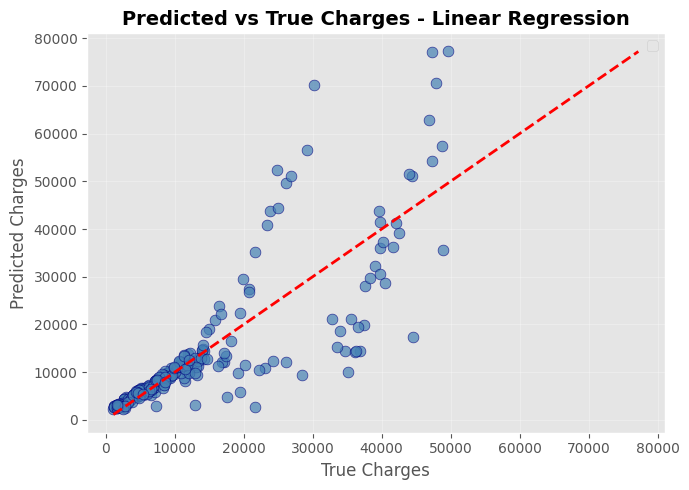

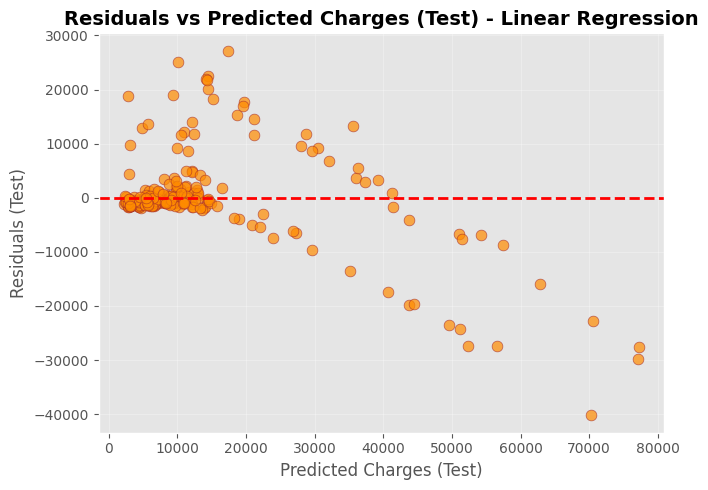

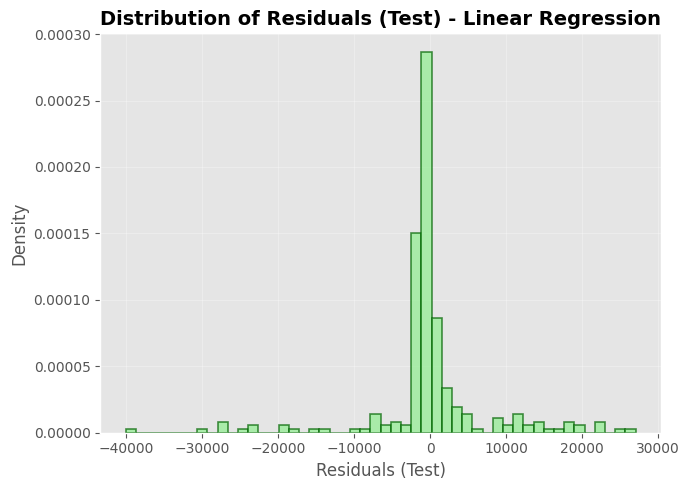

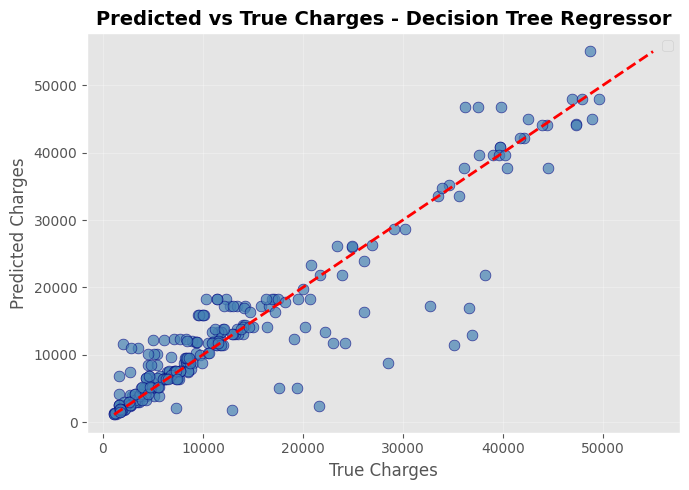

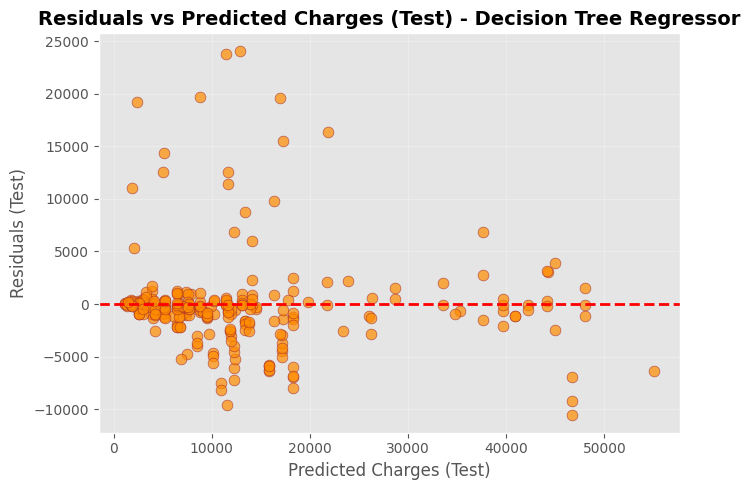

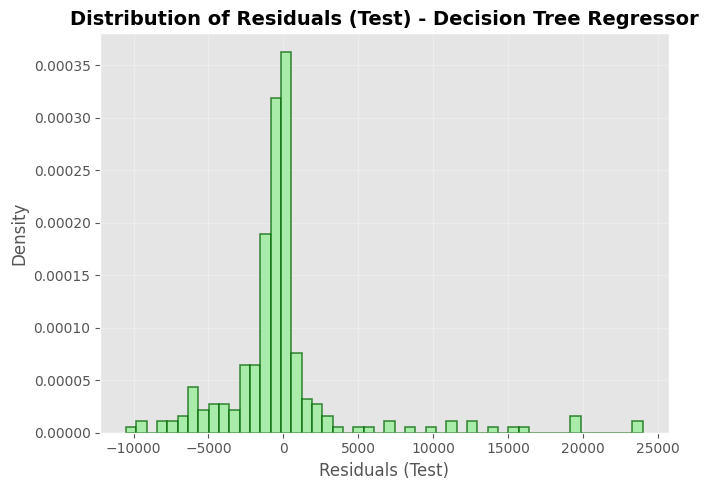

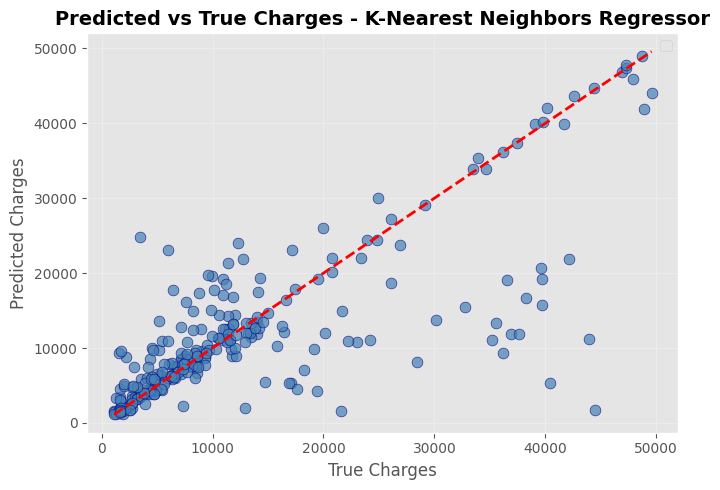

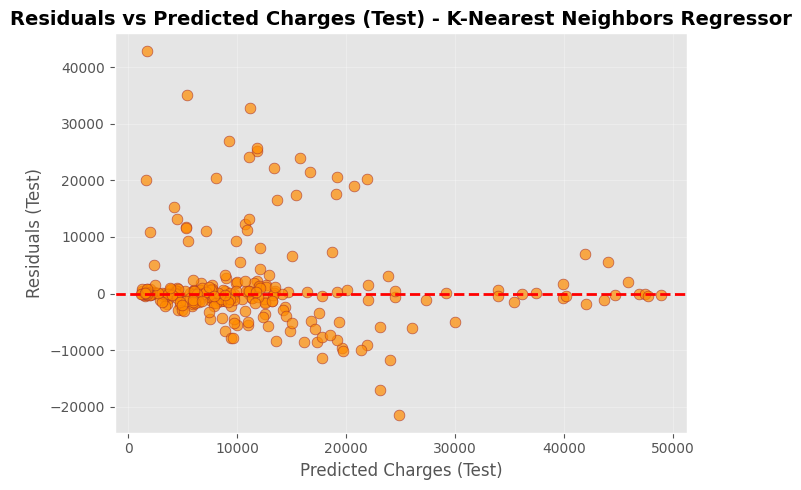

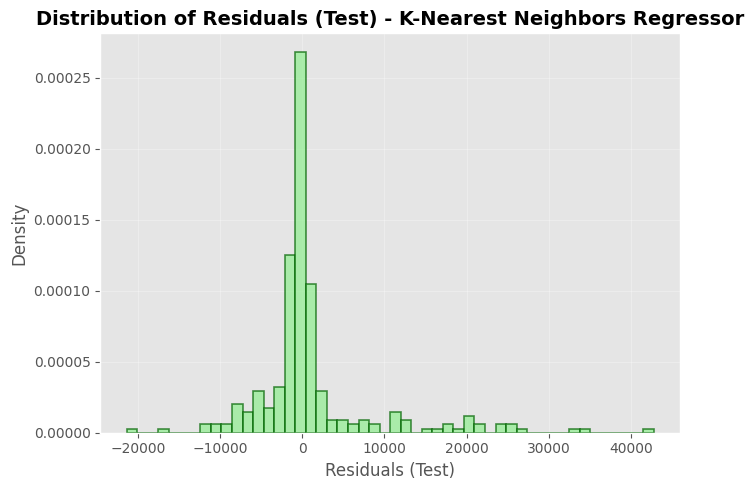

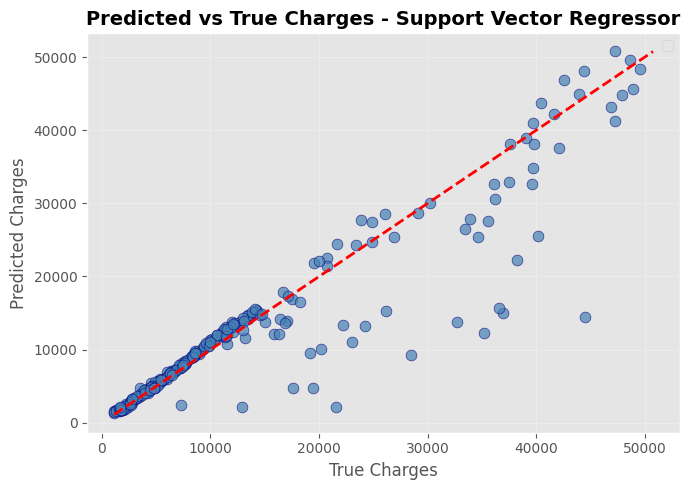

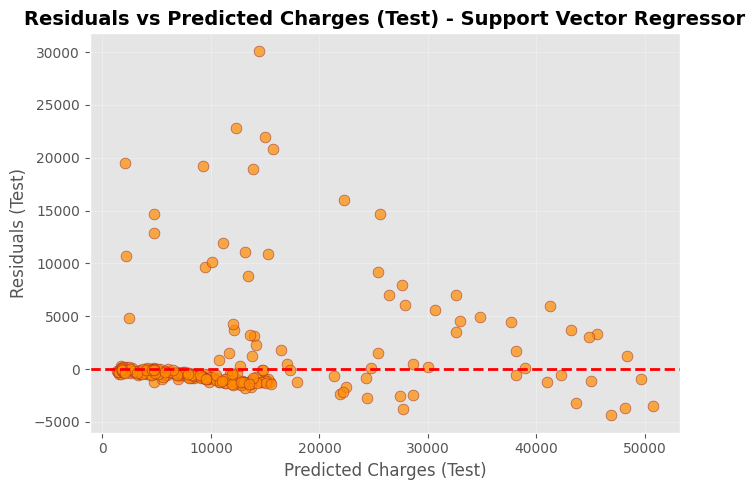

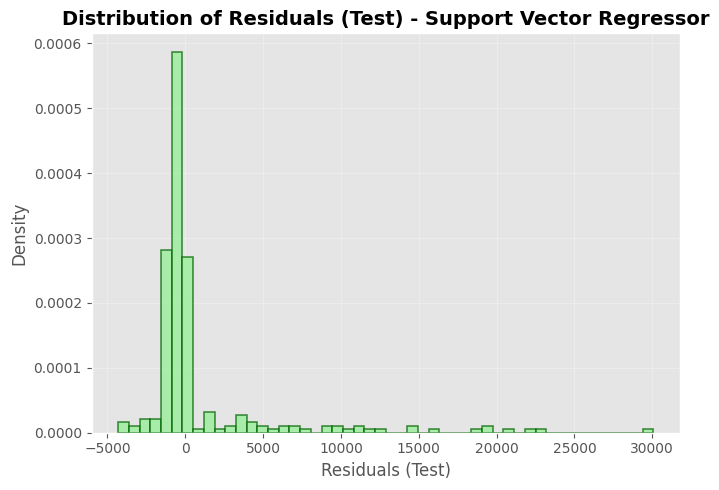

In [41]:
plt.style.use('ggplot')

for model in results:
    fig_size = (7, 5)

    plt.figure(figsize=fig_size)
    plt.scatter(results[model]["y_test"], results[model]["y_test_pred"],
                alpha=0.7, s=60, color='steelblue', edgecolors='navy', linewidth=0.5)
    min_val = min(min(results[model]["y_test"]), min(results[model]["y_test_pred"]))
    max_val = max(max(results[model]["y_test"]), max(results[model]["y_test_pred"]))
    plt.plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2)
    plt.grid(True, alpha=0.3)
    plt.xlabel("True Charges", fontsize=12)
    plt.ylabel("Predicted Charges", fontsize=12)
    plt.title(f"Predicted vs True Charges - {model}", fontsize=14, fontweight='bold')
    plt.legend()
    plt.tight_layout()
    plt.show()

    #Residual Plot (Test)
    residuals = results[model]["y_test"] - results[model]["y_test_pred"]
    plt.figure(figsize=fig_size)
    plt.scatter(results[model]["y_test_pred"], residuals,
                alpha=0.7, s=60, color='darkorange', edgecolors='brown', linewidth=0.5)
    plt.axhline(y=0, color='r', linestyle='--', linewidth=2)
    plt.grid(True, alpha=0.3)
    plt.xlabel("Predicted Charges (Test)", fontsize=12)
    plt.ylabel("Residuals (Test)", fontsize=12)
    plt.title(f"Residuals vs Predicted Charges (Test) - {model}", fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()

    #Histogram of Residuals (Test)
    plt.figure(figsize=fig_size)
    plt.hist(residuals, bins=50, density=True, color='lightgreen',
             edgecolor='darkgreen', linewidth=1.2, alpha=0.7)
    plt.grid(True, alpha=0.3)
    plt.xlabel("Residuals (Test)", fontsize=12)
    plt.ylabel("Density", fontsize=12)
    plt.title(f"Distribution of Residuals (Test) - {model}", fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()